### <span style="color: red">현재 실습 환경의 스파크는 worker node의 기본 출력과 에러 결과는 root/hadoop/logs/userlog/container 안에 있다. </span>
- 단 위 경로의 컨테이너 파일들은 spark shell이 실행되는 동안만 유지가 되고 shell이 종료되면 자동 삭제가 됨.
- 전체 로그는 /root/hadoop/logs 안에 전체 로그가 기록이 되며 영구기록된다.
- 로그관리는 일정기간 경과되면 로그파일은 삭제하던가 이동관리를 진행한다.
- 현재 실습환경은 클러스터로 연결되어 있음.
  - hadoop -> spark -> pyspark -> jupyter server
  - 독립적인 pyspark sc하고는 다른 환경 : 독립적인 환경은 local에서 사용할 수 있다. server-client는 위처럼 해야함.
  - 그렇기 때문에 spark context인 sc는 생성하지 않고 sparkshell이 제공하는 객체를 그냥 쓰면된다.
  - spark shell이 sc 라는 객체 변수를 바로 사용가능하게 한다.
  - 그리고 spark session은 spark라는 객체변수로 제공이 된다.

- RDD는 데이터 마트 전까지에서 쓰인다. 
- 그 이후로는 판다스를 쓰는것이 유리하지만(기능이 다양하기 때문에) 
- 그 전까지는 빠른 속도와 복원가능성 때문에 RDD를 쓰는것이다.

# Transformation - Action

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# RDD Transformation

-  데이터를 가공하기 위한 논리적 실행계획
  - 계획이 확정될 때 까지(Action 함수가 적용될 때 까지) 지연연산(연산방법을 기록만 하고 연산은 진행하지않음)을 진행
-  기존의 RDD에 연산이 반영된 새로운 RDD를 반환한다.

# Transformation 메서드

1. filter()
2. map()
3. flatMap()
4. distinct()
5. zip()
6. join()
6. reduceByKey()
7. mapValues()
8. flatMapValues()
9. sortBy()
10. groupByKey()

- 나는 스파크와 관련된 일을 하겠다를 파이썬에게 전달하기 위해 pyspark를 설치했고
- 스파크명령어 sc를 이용했다.

In [2]:
# from pyspark import SparkContext, SparkConf

In [3]:
# sc.stop()

In [4]:
# conf = SparkConf().setAppName('mysite').setMaster('local')
# sc = SparkContext(conf=conf)

## Transformation - filter()

In [3]:
# jupyter로 pyspark 열면 없어도 됨
# parallelize 메서드로 생성
data = [1, 2, 3, 4, 5]
# rdd로 만들 데이터, 파티셔닝 수
rdd1 = sc.parallelize(data, 10)
# 외부파일
score_rdd = sc.textFile('/rdd/score.txt', 20)
score_rdd.collect()
rdd2 = sc.range(1, 10, 2, 3) # 3개의 파티션으로 생성

['김철수 스파크 50',
 '홍길동 스파크 80',
 '임꺽정 스파크 60',
 '임요환 텐서플로우 100',
 '홍진호 텐서플로우 22',
 '홍진호 텐서플로우 22',
 '이윤열 텐서플로우 90']

In [6]:
# 이것들이 지연연산인지 확인하는 방법...
# -> 위에서 읽을 때 오타를 내서 에러를 내보자. 오타인데 에러가 나지 않는다면 지연연산이다.
# 예시로 score_rdd = sc.textFile('/rdd/score.txt', 20)에서 경로에 오타를 내보자. 액션을 할 때 에러가 감지될것이다.
rdd1
score_rdd
rdd2

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:274

/rdd/score.txt MapPartitionsRDD[2] at textFile at NativeMethodAccessorImpl.java:0

PythonRDD[4] at RDD at PythonRDD.scala:53

In [23]:
# filter()
# 조건에 맞는 데이터만
score_rdd.filter(lambda e : '스파크' in e).collect()

['김철수 스파크 50', '홍길동 스파크 80', '임꺽정 스파크 60']

## Transformation - map(함수)
- 각 요소별로 적용한 결과를 합해서 rdd로 반환
  

In [26]:
# map()
# 각각의 요소에 적용
rdd2.map(lambda e: e*2)
rdd2.map(lambda e: e*2).collect() # 연산진행.
rdd2.collect()

[2, 6, 10, 14, 18]

[1, 3, 5, 7, 9]

## Transformation - flatMap(함수)

In [34]:
# flatMap()
# 각각의 요소에 함수를 적용한(여기까지는 map과 동일) 다음 평면화(flat) 시켜준다.
# 복잡한 중첩구조의 데이터를 다루어야 할 때 편하게 다룰 수 있다.

nlist = [[1, 2, 3], 
         [4, 5, 6], 
         [7, 8, 9]]
flat_rdd = sc.parallelize(nlist) # rdd 객체 생성

def append_data(e):
    e.append(100)
    return e

res = flat_rdd.flatMap(lambda e : append_data(e)).collect()
len(res) 
res

12

[1, 2, 3, 100, 4, 5, 6, 100, 7, 8, 9, 100]

In [13]:
# iterable이 아닌 요소가 RDD안에 존재한다면 flatMap은 사용할 수 없다.

tmp = [[1, 2, 3,], 4, 5]
# sc.parallelize(tmp).flatMap(lambda e : e).collect() #TypeError: 'int' object is not iterable

In [42]:
# flatMap()
# 각각의 요소에 함수를 적용한 다음 평면화(flat) 시켜 준다,
# 문자열도 문자들의 배열이기 때문에 각 문자로 분리해준다.
# score_rdd.collect()
# res = score_rdd.flatMap(lambda e : e+'점').collect()
# res

# 연습문제 : filter, map, flatMap 

nlist안의 요소들중 홀수인 요소만 추출하여 100을 곱하여 list로 반환하시오  

 - nlist = [[[1, 2], [3, 4, 5]],[[6, 7], [8, 9, 10, 11]],[[12,13,14,15], [16, 17]]]

 - 결과 : [100, 300, 500, 700, 900, 1100, 1300, 1500, 1700]

In [46]:
# 연습문제
# nlist안의 요소들중 홀수인 요소만 추출하여 100을 곱하여 list로 반환하시오
# 결과 : [100, 300, 500, 700, 900, 1100, 1300, 1500, 1700]

nlist = [[[1, 2], [3, 4, 5]], 
         [[6, 7], [8, 9, 10, 11]], 
         [[12,13,14,15], [16, 17]]]

flat_rdd3 = sc.parallelize(nlist)
flat_rdd3.collect()

[[[1, 2], [3, 4, 5]], [[6, 7], [8, 9, 10, 11]], [[12, 13, 14, 15], [16, 17]]]

In [51]:
res = flat_rdd3.flatMap(lambda e : e ).flatMap(lambda e : e )\
        .filter(lambda e : e % 2 == 1)\
        .map(lambda e : e * 100)


res.collect()


[100, 300, 500, 700, 900, 1100, 1300, 1500, 1700]

## Transformation - distinct()

In [9]:
# distinct : 중복 제거

nlist = [1, 2, 3, 1, 2, 3, 1, 2, 3 , 4, 5]
dist_rdd = sc.parallelize(nlist)
dist_rdd.collect()
dist_rdd.distinct().collect()




[1, 2, 3, 1, 2, 3, 1, 2, 3, 4, 5]

[2, 4, 3, 1, 5]

In [ ]:

slist = ['안녕','반가워','hello','hello']

## Transformation - zip()
- 두 개의 집합 객체를 전달 받아서 인덱스가 동일한 원소들 끼리 튜플로 묶어서 반환
- 인덱스 번호가 같은 데이터끼리 튜플로 묶는다. 

In [13]:
# zip() : 두 rdd를 결합해 하나의 key-value 형태의 하나의 rdd(Pair RDD)로 생성

foods = ['파스타','스테이크', '불고기', '비빔밥', '김치']
category = ['양식', '양식', '한식', '한식', '한식']

food_rdd = sc.parallelize(foods)
category_rdd = sc.parallelize(category)

In [18]:
# tuple의 0번인덱스가 key, 1번 인덱스가 value
zip_rdd = category_rdd.zip(food_rdd)
zip_rdd
zip_rdd.collect()

org.apache.spark.api.java.JavaPairRDD@62bbf51

[('양식', '파스타'), ('양식', '스테이크'), ('한식', '불고기'), ('한식', '비빔밥'), ('한식', '김치')]

In [11]:
# 길이가 2인  tuple로 이루어진 list는 key-value 형태의 rdd로 생성이 가능하다.

foods = ['파스타','스테이크', '불고기', '비빔밥', '김치']
category = ['양식', '양식', '한식', '한식', '한식']
tmp = list(map(lambda(a,b : (a, b), category, foods))
2강의 27분부터

## Transformation - reduceByKey(), mapValues()

In [19]:
# reduceByKey, 키값을 기준으로 value값들을 연산
# mapValues, Pair RDD의 value들에 대해 map연산
# 키값을 기준으로 값들을 결합


In [20]:
# 카테고리로 오름차순

# 메뉴 가짓 수로 내림차순


In [21]:
foods = ['파스타','스테이크','호빵', '불고기', '비빔밥', '김치']
category = ['양식', '양식', '한식','한식', '한식', '한식']



# 연습문제 : distinct, zip, reduceByKey, sortBy 
 - hdfs의 /score.txt 파일을 읽어와 RDD로 생성하시오
 - 각 과목별 명단을 추출하시오
 - 각 과목별 평균점수를 추출하시오
 - 이때 중복으로 들어간 홍진호의 데이터는 한번만 적용되도록 합니다.  
 
 
 
 - 결과 :  
 [('스파크', {'명단': ['하명도', '홍길동', '임꺽정']}), ('텐서플로우', {'명단': ['임요환', '홍진호', '이윤열']})]       
  
 [('스파크', {'평균점수': 63.333333333333336}), ('텐서플로우', {'평균점수': 70.66666666666667})]

In [20]:
# 지정한 DataSource에서 데이터를 읽어와 RDD를 생성
# score_rdd = sc.textFile('/rdd/score.txt')
score_rdd.collect()



['김철수 스파크 50',
 '홍길동 스파크 80',
 '임꺽정 스파크 60',
 '임요환 텐서플로우 100',
 '홍진호 텐서플로우 22',
 '홍진호 텐서플로우 22',
 '이윤열 텐서플로우 90']

In [39]:
# 각 과목별 명단을추출
# 1. 중복데이터를 제거
base = score_rdd.distinct()

In [28]:
base_pair = base.map(lambda e:e.split(' '))\
        .map(lambda e : (e[1], e[0]))
base_pair.collect()

[('텐서플로우', '이윤열'),
 ('스파크', '홍길동'),
 ('스파크', '김철수'),
 ('스파크', '임꺽정'),
 ('텐서플로우', '임요환'),
 ('텐서플로우', '홍진호')]

In [29]:
# 3. key를 기준으로 value들을 결합
base_pair.reduceByKey(lambda a, b : a + b).collect()


[('스파크', '김철수임꺽정홍길동'), ('텐서플로우', '이윤열임요환홍진호')]

In [30]:
# 4. base_pair_reduce에 value에 명단 키 추가
base_pair.mapValues(lambda e : {'명단' :e}).collect()

[('스파크', {'명단': '홍길동'}),
 ('텐서플로우', {'명단': '이윤열'}),
 ('텐서플로우', {'명단': '홍진호'}),
 ('스파크', {'명단': '김철수'}),
 ('스파크', {'명단': '임꺽정'}),
 ('텐서플로우', {'명단': '임요환'})]

In [34]:
# 체인으로 한꺼번에 해보기
 # 애초에 리스트로 만들어보기 e[0] -> [e[0]]
std = score_rdd.distinct()\
    .map(lambda e : e.split(' '))\
    .map(lambda e : (e[1], [e[0]]))\
    .reduceByKey(lambda a, b : a + b)\
    .mapValues(lambda e : {'명단':e})
std.collect()

[('스파크', {'명단': ['홍길동', '김철수', '임꺽정']}),
 ('텐서플로우', {'명단': ['홍진호', '임요환', '이윤열']})]

In [40]:
# 과목별 평균
# 1. 중복제거된 base RDD객체를 사용
base = base.map(lambda e:e.split(' '))
base.collect()

[['홍길동', '스파크', '80'],
 ['이윤열', '텐서플로우', '90'],
 ['홍진호', '텐서플로우', '22'],
 ['김철수', '스파크', '50'],
 ['임꺽정', '스파크', '60'],
 ['임요환', '텐서플로우', '100']]

In [41]:
sub_avg = base.map(lambda e : (e[1], [int(e[2])]))\
        .reduceByKey(lambda a, b : a + b)\
        .mapValues(lambda e : {'평균점수': sum(e)/len(e)})
sub_avg.collect()

[('스파크', {'평균점수': 63.333333333333336}), ('텐서플로우', {'평균점수': 70.66666666666667})]

## Transformation - join()
- RDD객체1.join(RDD객체2)
- 두 RDD객체의 key를 기준으로 key값이 같은 요소들끼리 결합

- sutdent RDD = [('스파크', {'명단': ['홍길동', '김철수', '임꺽정']}),
 ('텐서플로우', {'명단': ['홍진호', '임요환', '이윤열']})]
- sub_avg = [('스파크', {'평균점수': 63.333333333333336}), ('텐서플로우', {'평균점수': 70.66666666666667})]
- 위 RDD 객체는 pair RDD고 key가 동일한 형태이다. 과목을 key로 갖고있음 - join 함수를 사용해서 과목 value를 결합

In [48]:
# join : 키를 기준으로 두 RDD를 결합
res = std.join(sub_avg)
res.collect()

[('스파크', ({'명단': ['홍길동', '김철수', '임꺽정']}, {'평균점수': 63.333333333333336})),
 ('텐서플로우', ({'명단': ['홍진호', '임요환', '이윤열']}, {'평균점수': 70.66666666666667}))]

In [45]:
d = {'명단': ['홍길동', '김철수', '임꺽정']}
iter(d.items())

In [24]:
# 미션! 키당 하나의 딕셔너리 객체만 나오게끔 작성해보기
#[('스파크', {'명단': ['임꺽정', '하명도', '홍길동'], '평균점수': 63.333333333333336}),
# ('텐서플로우', {'명단': ['이윤열', '홍진호', '임요환'], '평균점수': 70.66666666666667})]


In [52]:
res.mapValues(lambda e : list(iter(e[0].items()))).collect()

[('스파크', [('명단', ['홍길동', '김철수', '임꺽정'])]),
 ('텐서플로우', [('명단', ['홍진호', '임요환', '이윤열'])])]

In [ ]:
res = std.join(avg)\
        .mapValues(
            
        )

# Spark Shuffle

- 스파크에서 연산은 단일 파티션에서 작동된다.
  - 연산을 진행하기 위해서는 data가 한곳에 모여 있어야 함.


- reduceByKey와 같이 특정 키에 매핑된 모든 값에 대한 연산을 수행하기 위해서는   
  파티션에 흩어진 특정키에 해당하는 값을 하나의 파티션으로 모아 줄 필요가 있음  
- 모든 키에 대한 모든 값을 찾기 위해 모든 파티션을 탐색하고, 해당하는 값들을 하나의 파티션으로 옮겨오는 과정을 **셔플**이라고 부른다.  
- shuffle은 특정 연산을 진행하기 위해 여러 파티션에 흩어져 있는 값들을 하나의 파티션으로 모으는 작업
- 디스크 IO 또는 네트워크 IO가 발생함으로 비용이 매우 비싼 작업  (IO가 모꼬?)


ex)   
filter : 각 파티션에 있는 하나의 튜플에 대해 조건을 탐색하면 됨으로 셔플 발생 x  
reduceByKey : 연산을 시작하기 위해서는 우선적으로 모든 파티션에 분산되어 있는 특정 키 값을 수집해야함으로 셔플 발생 
- 셔플이 발생하는 함수들 :
 - subtractByKey
 - groupBy
 - foldByKey
 - reduceByKey
 - aggregateByKey
 - transformations of a join of any type
 - distinct
 - cogroup
- 한번 모았을때 셔플있는 함수 다 적용해놔야 한다.

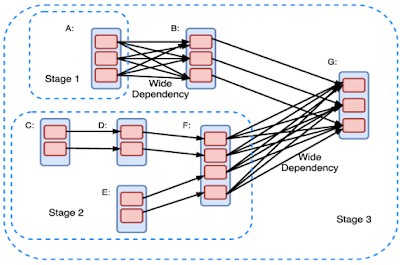

# RDD Action

- transformation 연산을 통해 생성한 논리적 실행계획을 최적화 하여 연산을 수행. 빠른 연산이 가능

## Action Method

1. collect()
2. take()
3. takeOrdered()
4. top()
5. countByValue()
6. foreach()
7. reduce()
8. saveAsTextFile()
9. max()
10. min()
11. mean()
12. variance()
13. stdev()
14. stats()

## Action - collect()

In [25]:
# collect : RDD안의 모든 데이터를 리스트로 반환


## Action - take()

In [26]:
# take : 인자로 받은 수량만큼 데이터를 리스트로 반환

data = [1, 2, 3, 4, 5]
data = [3, 5, 1, 4, 2]


## Action - takeOrdered()

In [27]:
# takeOrdered : 인자로 받은 수랑만큼 데이터를 오름차순으로 정렬하여 반환



## Action - top()

In [28]:
# top : 인자로 받은 수랑만큼 데이터를 내림차순으로 정렬하여 반환


## Action - countByValues()

In [32]:
chars = sc.parallelize(['a', 'a', 'b', 'b', 'b', 'c', 'c', 'd'])


## Action - reduce()

In [ ]:
# reduce : 각 요소에 대해 주어진 함수를 실행하고 하나의 결과를 반환
nums = sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


In [ ]:
# 원소를 줄여나감
# 3, 7, 11, 15, 19
# 10, 26, 19
# 36, 19
# 55

## Action - foreach()
- 데이터 세트의 각 요소를 반복/루프하기 위해 RDD, DataFrame 및 Dataset에서 사용할 수 있는 작업
- for고급 개념과 유사합
- foreach()는 함수가 값을 반환하지 않고 RDD, DataFrame 및 Dataset의 각 요소에 대해 입력 함수를 실행
- 즉 !
    - Spark foreach()는 반환 유형이 없고
    - 누산기를 조작하거나
    - 외부 데이터 소스를 작성하는 데 사용되는 RDD, DataFrame, Dataset의 작업

In [31]:
nums = sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


## Action - saveAsTextFile()

In [33]:
# saveASTextFile : rdd를 텍스트 파일로 저장

# 지정한 DataSource에서 데이터를 읽어와 RDD를 생성




[('스파크', {'명단': ['하명도', '홍길동', '임꺽정']}),
 ('텐서플로우', {'명단': ['임요환', '홍진호', '이윤열']})]

[('스파크', {'평균점수': 63.333333333333336}), ('텐서플로우', {'평균점수': 70.66666666666667})]

In [68]:
# join : 키를 기준으로 두 RDD를 결합


[('스파크', ({'명단': ['하명도', '홍길동', '임꺽정']}, {'평균점수': 63.333333333333336})),
 ('텐서플로우', ({'명단': ['임요환', '홍진호', '이윤열']}, {'평균점수': 70.66666666666667}))]

In [5]:
li = [('스파크', ({'명단': ['김철수', '홍길동', '임꺽정']}, {'평균점수': 63.333333333333336})),
 ('텐서플로우', ({'명단': ['임요환', '홍진호', '이윤열']}, {'평균점수': 70.66666666666667}))]


{'평균점수': 63.333333333333336}

In [81]:
# 미션! 키당 하나의 딕셔너리 객체만 나오게끔 작성해보기
#[('스파크', {'명단': ['임꺽정', '하명도', '홍길동'], '평균점수': 63.333333333333336}),
# ('텐서플로우', {'명단': ['이윤열', '홍진호', '임요환'], '평균점수': 70.66666666666667})]



[('스파크', {'명단': ['하명도', '홍길동', '임꺽정'], '평균점수': 63.333333333333336}),
 ('텐서플로우', {'명단': ['임요환', '홍진호', '이윤열'], '평균점수': 70.66666666666667})]

In [70]:
# 파티셔닝 되어 하둡에 디렉토리로 저장된 것을 확인 할 수 있다.


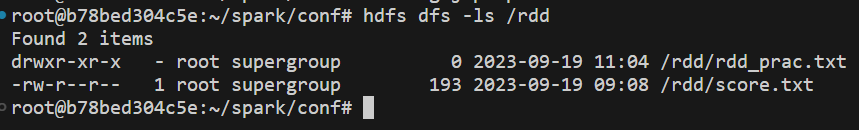

["('스파크', {'명단': ['하명도', '홍길동', '임꺽정'], '평균점수': 63.333333333333336})",
 "('텐서플로우', {'명단': ['임요환', '홍진호', '이윤열'], '평균점수': 70.66666666666667})"]

## Action - max, min, mean, variance, stdev, stats

In [34]:
nums = sc.parallelize([1, 4, 2, 3, 7, 6, 5], 1)

# max / min : 최대값 / 최소값


# mean : 평균


# variance : 분산


# stdev : 표준편차


# stats : count mean stdev max min

